# BigQuery Public Data Stackoverflow

## Dependency

In [87]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('expand_frame_repr', False)
plt.style.use('default')

## BigQuery client

In [2]:
bq = bigquery.Client()

## General trend

In [52]:
query = """
select
  extract(year from creation_date) as year,
  extract(month from creation_date) as month,
  count(*) as num_questions
from
  `bigquery-public-data.stackoverflow.posts_questions`
group by
  1,
  2
order by
  1,
  2
;
"""

df = bq.query(query).to_dataframe()
df['index'] = [datetime(y, m, 1) for y, m in zip(df['year'], df['month'])]
df = df.set_index('index')

In [53]:
df.head()

,year,month,num_questions
index,,,
2008-07-01,2008,7,4
2008-08-01,2008,8,3790
2008-09-01,2008,9,14169
2008-10-01,2008,10,14670
2008-11-01,2008,11,12789


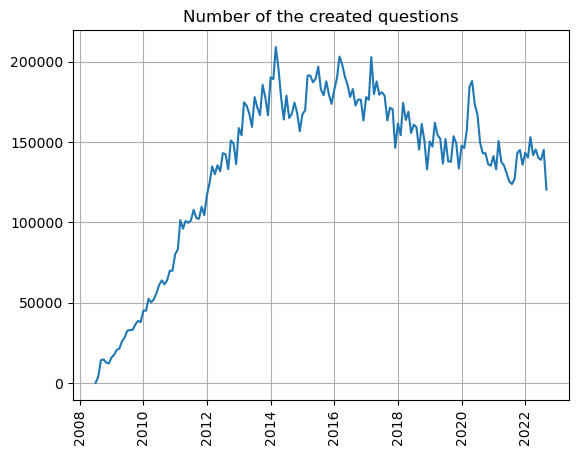

In [56]:
plt.plot(df['num_questions'])
plt.xticks(rotation=90)
plt.grid()
plt.title('Number of the created questions')
plt.show()

## Popular tags

In [108]:
query = """
with cte as (
  select
    id,
    creation_date,
    tag
  from
    `bigquery-public-data.stackoverflow.posts_questions`,
  unnest(split(tags, '|')) as tag
  where
    creation_date >= timestamp(date_sub(current_date(), interval 1 year))
)

select
  tag,
  count(*) as num_questions
from
  cte
group by
  1
order by
  2 desc
;
"""

df = bq.query(query).to_dataframe()

In [109]:
df.shape

(42794, 2)

In [110]:
df.head()

,tag,num_questions
0,python,206738
1,javascript,142929
2,reactjs,77276
3,java,66414
4,c#,55201


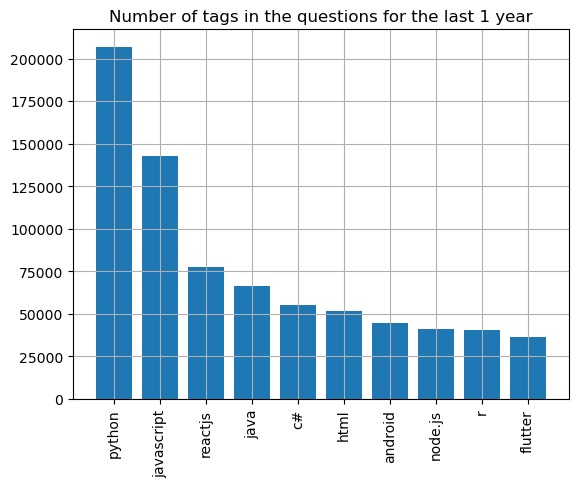

In [111]:
df_tmp = df.iloc[:10]

plt.bar(df_tmp['tag'], df_tmp['num_questions'])
plt.xticks(rotation=90)
plt.grid()
plt.title('Number of tags in the questions for the last 1 year')
plt.show()

In [113]:
df_tmp = df.iloc[:30]
popular_tags = df_tmp['tag']

In [114]:
popular_tags

0                  python
1              javascript
2                 reactjs
3                    java
4                      c#
5                    html
6                 android
7                 node.js
8                       r
9                 flutter
10                 pandas
11                    css
12                    php
13                    c++
14                    sql
15             typescript
16             python-3.x
17                 django
18                angular
19                 arrays
20              dataframe
21                  mysql
22                   json
23                   dart
24           react-native
25            spring-boot
26    amazon-web-services
27                  excel
28                  swift
29                      c
Name: tag, dtype: object

## Proportion

In [115]:
query = """
with

-- Monthly number of questions posted
cte1 as (
  select
    extract(year from creation_date) as creation_year,
    extract(month from creation_date) as creation_month,
    count(*) as num_questions
  from
    `bigquery-public-data.stackoverflow.posts_questions`
  group by
    1,
    2
),

-- Stack tag vertically
cte2 as (
  select
    creation_date,
    tag
  from
    `bigquery-public-data.stackoverflow.posts_questions`,
  unnest(split(tags, '|')) as tag
),

-- Monthly number of each tag
cte3 as (
  select
    extract(year from creation_date) as creation_year,
    extract(month from creation_date) as creation_month,
    tag,
    count(*) as num_tags
  from
    cte2
  group by
    1,
    2,
    3
)


select
  a.creation_year,
  b.creation_month,
  a.tag,
  a.num_tags,
  b.num_questions,
  a.num_tags / b.num_questions as proportion
from
  cte3 as a
left join
  cte1 as b
on
  a.creation_year = b.creation_year
  and a.creation_month = b.creation_month
order by
  1,
  2,
  6 desc
;
"""

df = bq.query(query).to_dataframe()

In [116]:
# Create index
df['index_month'] = [m + 1 if m != 12 else 1 for m in df['creation_month']]
df['index_year'] = [y + 1 if m == 1 else y for y, m in zip(df['creation_year'], df['index_month'])]
df['index'] = [datetime(y, m, 1) for y, m in zip(df['index_year'], df['index_month'])]
df['index'] -= timedelta(days=1)
df = df.set_index('index')

In [94]:
df.head()

,creation_year,creation_month,tag,num_tags,num_questions,proportion,index_month,index_year
index,,,,,,,,
2008-07-31,2008,7,c#,3,4,0.75,8,2008
2008-07-31,2008,7,datetime,2,4,0.50,8,2008
2008-07-31,2008,7,time,1,4,0.25,8,2008
2008-07-31,2008,7,internet-explorer-7,1,4,0.25,8,2008
2008-07-31,2008,7,type-conversion,1,4,0.25,8,2008


In [95]:
df.tail()

,creation_year,creation_month,tag,num_tags,num_questions,proportion,index_month,index_year
index,,,,,,,,
2022-09-30,2022,9,flexible-array-member,1,120414,0.000008,10,2022
2022-09-30,2022,9,sublime-text-plugin,1,120414,0.000008,10,2022
2022-09-30,2022,9,hessian-matrix,1,120414,0.000008,10,2022
2022-09-30,2022,9,ubuntu-21.04,1,120414,0.000008,10,2022
2022-09-30,2022,9,fortran-iso-c-binding,1,120414,0.000008,10,2022


Year: 2022, month: 9


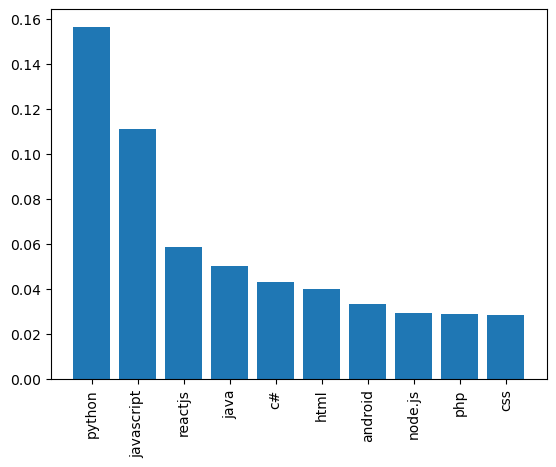

In [96]:
max_year = max(df['creation_year'])
max_month = max(df.loc[df['creation_year'] == max_year, 'creation_month'])

print(f'Year: {max_year}, month: {max_month}')

df_tmp = df.loc[
    (df['creation_year'] == max_year)
    & (df['creation_month'] == max_month)
]

df_tmp = df_tmp.sort_values(by='proportion', ascending=False)
df_tmp = df_tmp.head(10)

plt.bar(df_tmp['tag'], df_tmp['proportion'])
plt.xticks(rotation=90)
plt.show()

Year: 2022, month: 9


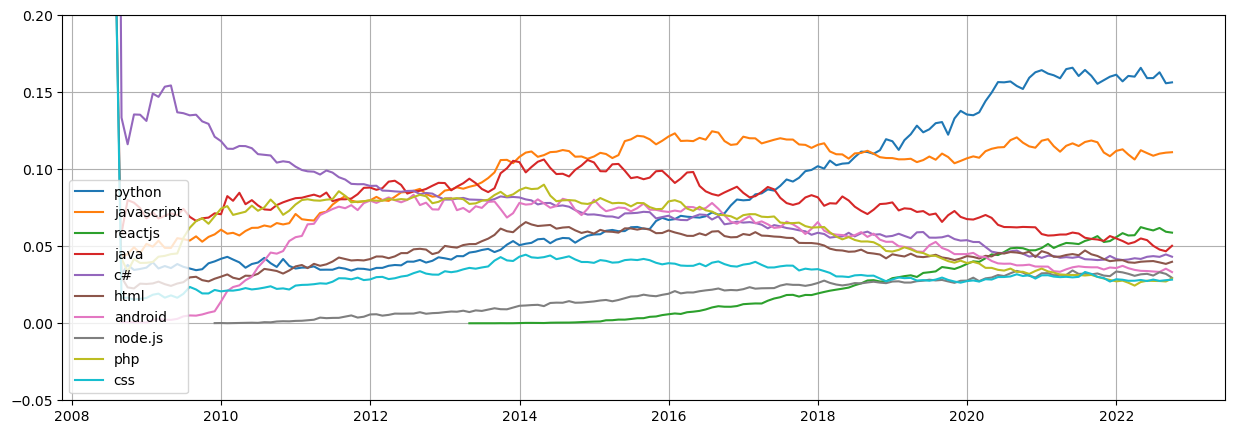

In [107]:
k = 10

max_year = max(df['creation_year'])
max_month = max(df.loc[df['creation_year'] == max_year, 'creation_month'])

print(f'Year: {max_year}, month: {max_month}')

df_tmp = df.loc[
    (df['creation_year'] == max_year)
    & (df['creation_month'] == max_month)
]

df_tmp = df_tmp.sort_values(by='proportion', ascending=False)
df_tmp = df_tmp.head(k)
tags = df_tmp['tag'].tolist()

plt.figure(figsize=(15, 5))
for tag in tags:

    df_tmp = df.loc[df['tag'] == tag]
    plt.plot(df_tmp['proportion'], label=tag)


plt.legend(loc='lower left')
plt.ylim(-0.05, 0.2)
plt.grid()
plt.show()

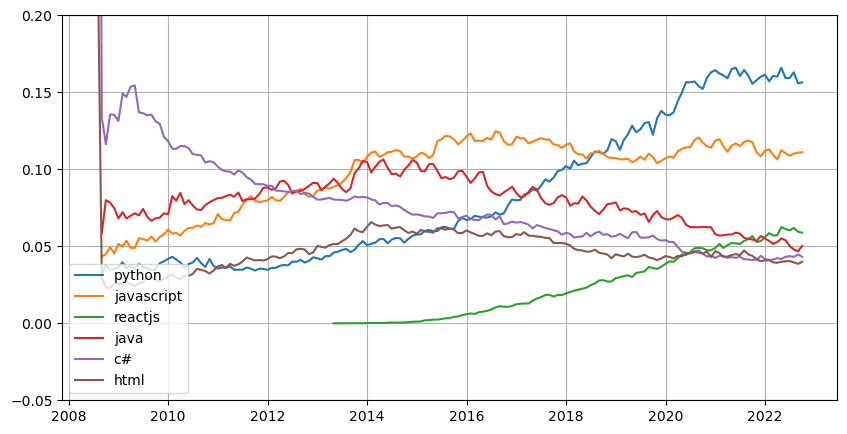

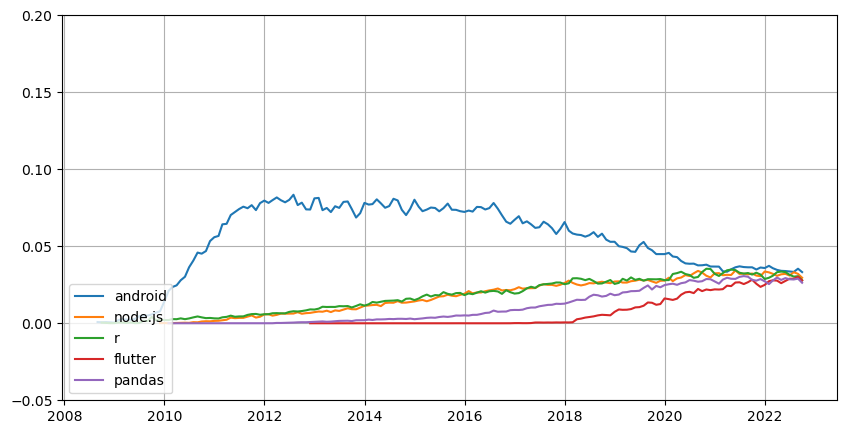

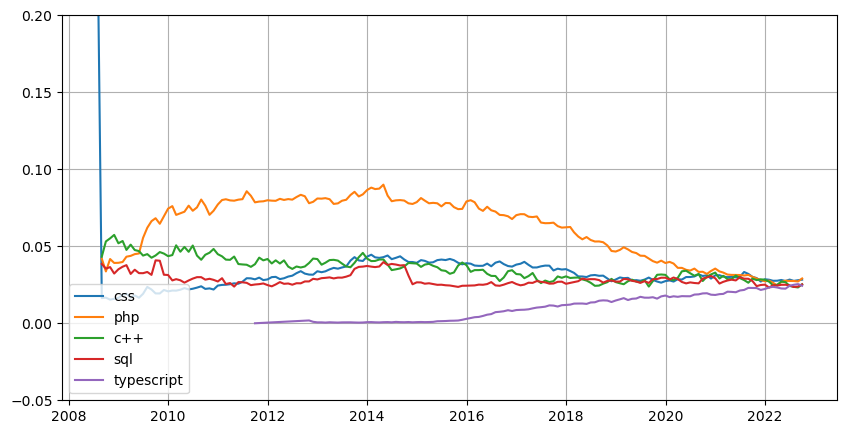

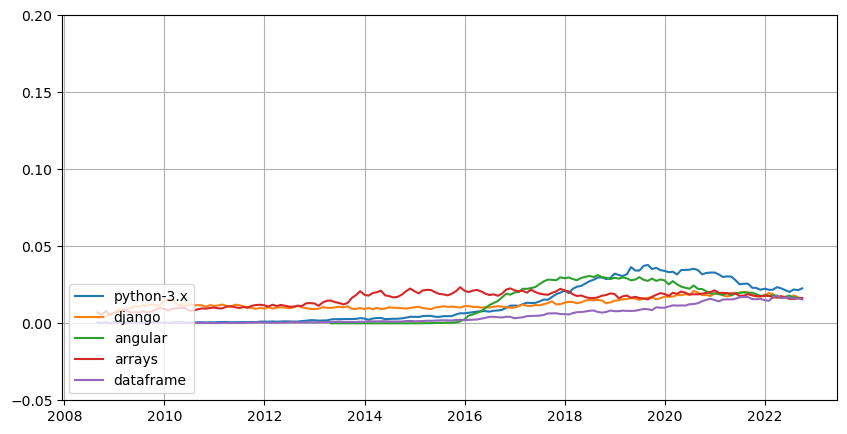

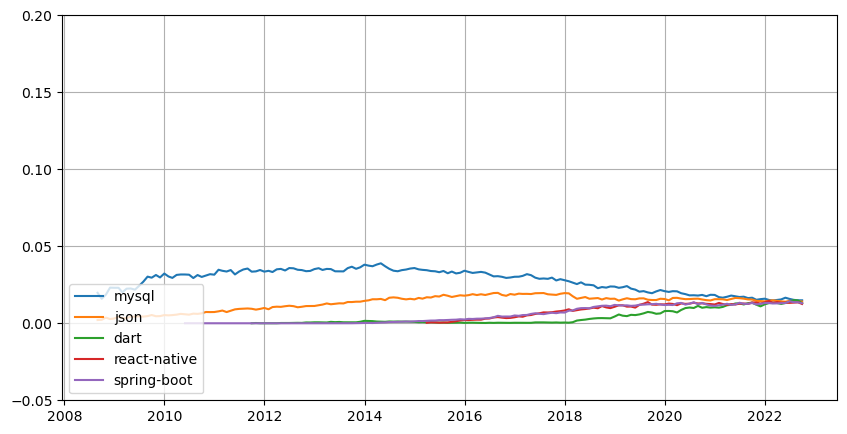

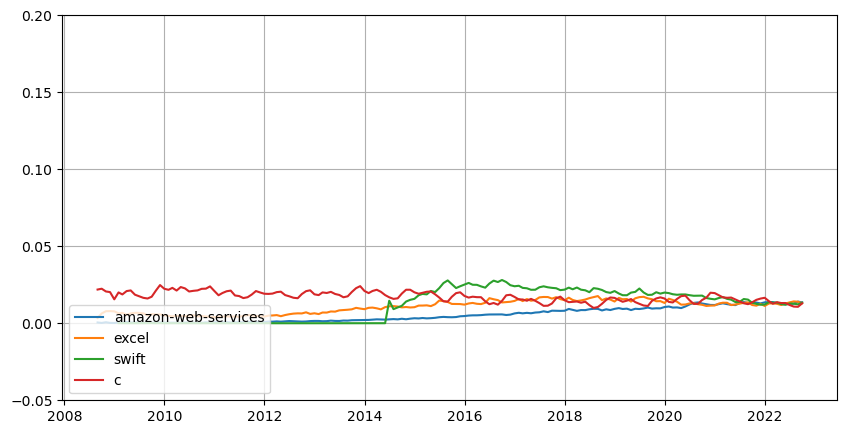

In [119]:
plt.figure(figsize=(10, 5))
for i, tag in enumerate(popular_tags):

    df_tmp = df.loc[df['tag'] == tag]
    plt.plot(df_tmp['proportion'], label=tag)

    if i != 0 and i % 5 == 0:
        plt.legend(loc='lower left')
        plt.ylim(-0.05, 0.2)
        plt.grid()
        plt.show()
        plt.figure(figsize=(10, 5))

plt.legend(loc='lower left')
plt.ylim(-0.05, 0.2)
plt.grid()
plt.show()

## Historical data

In [5]:
query = """
with 
cte1 as (
  select
    id,
    creation_date,
    tags,
    instr(tags, 'python') as search
  from
    `bigquery-public-data.stackoverflow.posts_questions`
)

select
  extract(year from creation_date) as year,
  extract(month from creation_date) as month,
  count(*) as c
from
  cte1
where
  search >= 1
group by
  1,
  2
order by
  1,
  2
;
"""

df = bq.query(query).to_dataframe()

In [8]:
df.head()

,year,month,c
0,2008,8,122
1,2008,9,548
2,2008,10,516
3,2008,11,456
4,2008,12,449


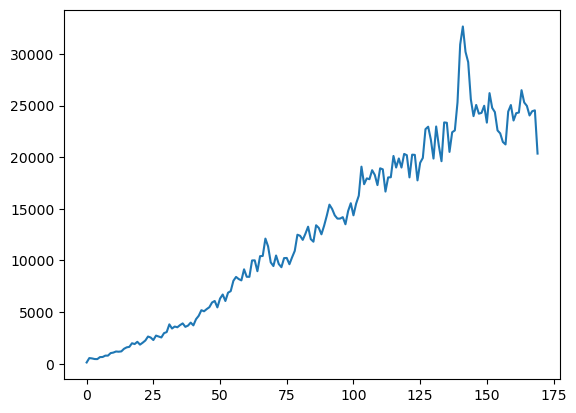

In [9]:
plt.plot(df['c'])
plt.show()